In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm

torch.cuda.empty_cache()

In [2]:
path='/kaggle/working/Cherry'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!mkdir /kaggle/working/Cherry

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Cherry* /kaggle/working/Cherry
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Cherry* /kaggle/working/Cherry

transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

dataset=ImageFolder(path,transform=transfrom)

train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*112*112, 2)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [5]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [6]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 191/191 [00:09<00:00, 19.34it/s]


Train Loss: 0.746 | Accuracy: 62.863


100%|██████████| 48/48 [00:00<00:00, 75.42it/s]


Test Loss: 0.670 | Accuracy: 49.902

Epoch : 2


100%|██████████| 191/191 [00:03<00:00, 55.63it/s]


Train Loss: 0.575 | Accuracy: 71.274


100%|██████████| 48/48 [00:00<00:00, 84.14it/s]


Test Loss: 0.537 | Accuracy: 76.852

Epoch : 3


100%|██████████| 191/191 [00:03<00:00, 56.08it/s]


Train Loss: 0.618 | Accuracy: 64.470


100%|██████████| 48/48 [00:00<00:00, 82.21it/s]


Test Loss: 0.624 | Accuracy: 54.623

Epoch : 4


100%|██████████| 191/191 [00:03<00:00, 54.43it/s]


Train Loss: 0.588 | Accuracy: 64.929


100%|██████████| 48/48 [00:00<00:00, 79.15it/s]


Test Loss: 0.585 | Accuracy: 74.557

Epoch : 5


100%|██████████| 191/191 [00:03<00:00, 50.49it/s]


Train Loss: 0.544 | Accuracy: 75.455


100%|██████████| 48/48 [00:00<00:00, 69.69it/s]


Test Loss: 0.517 | Accuracy: 81.180

Epoch : 6


100%|██████████| 191/191 [00:03<00:00, 54.12it/s]


Train Loss: 0.510 | Accuracy: 77.668


100%|██████████| 48/48 [00:00<00:00, 73.88it/s]


Test Loss: 0.507 | Accuracy: 77.967

Epoch : 7


100%|██████████| 191/191 [00:03<00:00, 55.74it/s]


Train Loss: 0.482 | Accuracy: 79.931


100%|██████████| 48/48 [00:00<00:00, 85.01it/s]


Test Loss: 0.464 | Accuracy: 82.164

Epoch : 8


100%|██████████| 191/191 [00:03<00:00, 56.05it/s]


Train Loss: 0.444 | Accuracy: 81.686


100%|██████████| 48/48 [00:00<00:00, 82.95it/s]


Test Loss: 0.453 | Accuracy: 81.115

Epoch : 9


100%|██████████| 191/191 [00:03<00:00, 54.67it/s]


Train Loss: 0.410 | Accuracy: 82.997


100%|██████████| 48/48 [00:00<00:00, 78.87it/s]


Test Loss: 0.414 | Accuracy: 83.344

Epoch : 10


100%|██████████| 191/191 [00:03<00:00, 56.59it/s]


Train Loss: 0.405 | Accuracy: 82.505


100%|██████████| 48/48 [00:00<00:00, 82.94it/s]


Test Loss: 0.423 | Accuracy: 82.098

Epoch : 11


100%|██████████| 191/191 [00:03<00:00, 56.33it/s]


Train Loss: 0.385 | Accuracy: 83.522


100%|██████████| 48/48 [00:00<00:00, 84.65it/s]


Test Loss: 0.403 | Accuracy: 83.607

Epoch : 12


100%|██████████| 191/191 [00:03<00:00, 52.79it/s]


Train Loss: 0.368 | Accuracy: 84.391


100%|██████████| 48/48 [00:00<00:00, 74.61it/s]


Test Loss: 0.376 | Accuracy: 84.393

Epoch : 13


100%|██████████| 191/191 [00:03<00:00, 50.77it/s]


Train Loss: 0.366 | Accuracy: 84.424


100%|██████████| 48/48 [00:00<00:00, 76.36it/s]


Test Loss: 0.370 | Accuracy: 84.984

Epoch : 14


100%|██████████| 191/191 [00:03<00:00, 53.82it/s]


Train Loss: 0.341 | Accuracy: 85.834


100%|██████████| 48/48 [00:00<00:00, 62.32it/s]


Test Loss: 0.393 | Accuracy: 83.672

Epoch : 15


100%|██████████| 191/191 [00:03<00:00, 51.74it/s]


Train Loss: 0.337 | Accuracy: 85.916


100%|██████████| 48/48 [00:00<00:00, 71.41it/s]


Test Loss: 0.382 | Accuracy: 84.328

Epoch : 16


100%|██████████| 191/191 [00:03<00:00, 51.33it/s]


Train Loss: 0.330 | Accuracy: 85.998


100%|██████████| 48/48 [00:00<00:00, 78.36it/s]


Test Loss: 0.393 | Accuracy: 84.066

Epoch : 17


100%|██████████| 191/191 [00:03<00:00, 56.41it/s]


Train Loss: 0.314 | Accuracy: 86.916


100%|██████████| 48/48 [00:00<00:00, 82.76it/s]


Test Loss: 0.347 | Accuracy: 85.836

Epoch : 18


100%|██████████| 191/191 [00:03<00:00, 56.82it/s]


Train Loss: 0.310 | Accuracy: 87.031


100%|██████████| 48/48 [00:00<00:00, 82.99it/s]


Test Loss: 0.373 | Accuracy: 84.393

Epoch : 19


100%|██████████| 191/191 [00:03<00:00, 56.84it/s]


Train Loss: 0.303 | Accuracy: 87.227


100%|██████████| 48/48 [00:00<00:00, 79.68it/s]


Test Loss: 0.330 | Accuracy: 86.885

Epoch : 20


100%|██████████| 191/191 [00:03<00:00, 50.91it/s]


Train Loss: 0.293 | Accuracy: 88.342


100%|██████████| 48/48 [00:00<00:00, 78.31it/s]

Test Loss: 0.331 | Accuracy: 86.557


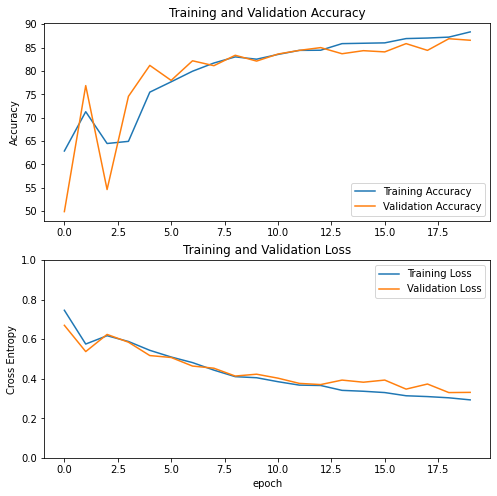

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()